# SYNTHENTIC DATA PROJECT

FILENAME: synthetic_data.ipynb
    
PROJECT: Randomized Data Model

DATE CREATED: 27-MAY-20

DATE UPDATED: 14-AUG-20

The purpose of this notebook is to create and replicate the core funtionalities of the on site budgeted and execution based tables.  The end product are two distinct dataframes, 'budget_table' & 'execution_table' and is capable of upload into either the Postgresql environment for storage, or directly into 3rd party visualization tools such as Tableau and Power BI for follow-on visualization activities.

## PHASE 1: PROJECT SETUP

In [95]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

Import the necessary libraries needed for ETL, engineering, and export efforts

In [96]:
import pandas as pd
import csv
import random
import sqlite3
import itertools
import numpy as np
import datetime
from itertools import repeat
import time as t
import getpass as gp

# plotting modules
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.offline as po
import plotly.graph_objects as go

import networkx as nx

Create a function which creates a dataframe with a length 'df_length' and randomizes the distribution of values as each year progresses

- Column names include: 'projects', 'subprojects', 'programs', 'rca'
- Budget years include:  'year 3 forecast', 'year 2 forecast', 'year 1 forecast', 'planned value', 'appropriation value', 'obligated value'



In [97]:
def init_array(df_length):
    '''
    DESCRIPTION: A function to create and return a two_dimensional array with randomized float values
    '''
    
    length = df_length
    
    num_of_projects = 20 # can change the amount of projects
    num_of_subprojects = 40 # can change the amount of subprojects
    num_of_rca = 80 # can change the amount of RCAs
    num_of_programs = 120 # number of programs

    # create a sequential list of column values for projects, subprojects, and RCAs
    proj_list = ['project-' + str(i+1) for i in range(num_of_projects)] # create a list of project names
    subproject_list = ['subproject-' + str(i+1) for i in range(num_of_subprojects)] # create a list of subproject names
    rca_list = ['rca-' + str(i+1) for i in range(num_of_rca)] # create a list of RCAs
    program_list = ['program-' + str(i+1) for i in range(num_of_programs)] # create a list of program names

    
    # create lists of each for each of the ordinal column values
    project_values = []
    subproject_values = []
    rca_values = []
    program_values = []

    
    for index in range(length):
        
        # select a random value from each list
        proj_val = random.choice(proj_list)
        sb_val = (random.choice(subproject_list))
        program_val = random.choice(program_list)
        rca_val = random.choice(rca_list)
        
        # append the randomized value to the default list
        project_values.append(proj_val)
        subproject_values.append(sb_val)
        program_values.append(program_val)
        rca_values.append(rca_val)
    
    # create randomized budget data, 6 x columns in total (3-2-1 forecast, plan, approp, oblig)
    yr3_forecast= np.random.randint(low = 1000, high = 30000, size = df_length) 
    yr2_random = np.random.uniform(low=0.5, high=1.3, size=df_length)
    yr2_forecast = np.round(yr3_forecast * yr2_random,2)
    
    yr1_random = np.random.uniform(low=0.8, high=1.2, size=df_length)
    yr1_forecast = np.round(yr2_forecast * yr1_random,2)
    
    plan_random = np.random.uniform(low=0.6, high=1.3, size=df_length)
    plan_val = np.round(yr1_forecast * plan_random,2)
    
    approp_random = np.random.uniform(low=0.6, high=1.2, size=df_length)
    approp_val = np.round(plan_val * approp_random,2)
    
    oblig_random = np.random.uniform(low=0.8, high=1.0, size=df_length)
    oblig_val = np.round(approp_val * oblig_random,2)
    
    # create the empty dataframe with the required columns
    raw_df = pd.DataFrame(columns=['project', 'subproject', 'rca','program_title', 'yr3_forecast','yr2_forecast','yr1_forecast','yr0_plan','yr1_approp','yr2_oblig'])

    # assign the list values to the columns in the master dataframe
    raw_df['project'] = project_values
    raw_df['subproject'] = subproject_values
    raw_df['rca'] = rca_values
    raw_df['program_title'] = program_values

    raw_df['yr3_forecast'] = yr3_forecast
    raw_df['yr2_forecast'] = yr2_forecast
    raw_df['yr1_forecast'] = yr1_forecast
    raw_df['yr0_plan'] = plan_val
    raw_df['yr1_approp'] = approp_val
    raw_df['yr2_oblig'] = oblig_val
    
    return raw_df # return the dataframe object

Sankey visualization function - used to plot data located in the passed dataframe argument

In [98]:
def genSankey(df,cat_cols=[],value_cols='',title='Sankey Diagram'):
    # maximum of 6 value cols -> 6 colors
    colorPalette = ['#4B8BBE','#306998','#FFE873','#FFD43B','#646464']
    labelList = []
    colorNumList = []
    for catCol in cat_cols:
        labelListTemp =  list(set(df[catCol].values))
        colorNumList.append(len(labelListTemp))
        labelList = labelList + labelListTemp
        
    # remove duplicates from labelList
    labelList = list(dict.fromkeys(labelList))
    
    # define colors based on number of levels
    colorList = []
    for idx, colorNum in enumerate(colorNumList):
        colorList = colorList + [colorPalette[idx]]*colorNum
        
    # transform df into a source-target pair
    for i in range(len(cat_cols)-1):
        if i==0:
            sourceTargetDf = df[[cat_cols[i],cat_cols[i+1],value_cols]]
            sourceTargetDf.columns = ['source','target','count']
        else:
            tempDf = df[[cat_cols[i],cat_cols[i+1],value_cols]]
            tempDf.columns = ['source','target','count']
            sourceTargetDf = pd.concat([sourceTargetDf,tempDf])
        sourceTargetDf = sourceTargetDf.groupby(['source','target']).agg({'count':'sum'}).reset_index()
        
    # add index for source-target pair
    sourceTargetDf['sourceID'] = sourceTargetDf['source'].apply(lambda x: labelList.index(x))
    sourceTargetDf['targetID'] = sourceTargetDf['target'].apply(lambda x: labelList.index(x))
    
    # creating the sankey diagram
    data = dict(
        type='sankey',
        node = dict(
          pad = 15,
          thickness = 20,
          line = dict(
            color = "black",
            width = 0.5
          ),
          label = labelList,
          color = colorList
        ),
        link = dict(
          source = sourceTargetDf['sourceID'],
          target = sourceTargetDf['targetID'],
          value = sourceTargetDf['count']
        )
      )
    
    layout =  dict(
        title = title,
        font = dict(
          size = 10
        )
    )
       
    fig = dict(data=[data], layout=layout)
    return fig



# PHASE 2: FUNCTION TEST

Invoke the 'init_array' function in order to create a sample budgetary data set of 10,000 records

In [99]:
train_df = init_array(10000)
train_df.tail(10)

project     subproject     rca program_title  yr3_forecast  \
9990  project-19  subproject-11  rca-51    program-65         24710   
9991  project-13  subproject-32  rca-17    program-61          6685   
9992  project-12   subproject-2  rca-42    program-10         16731   
9993  project-16  subproject-32  rca-24    program-61          9249   
9994  project-12  subproject-30  rca-24    program-84         27539   
9995  project-11   subproject-7  rca-73    program-62          9025   
9996  project-14  subproject-35  rca-31     program-2          1675   
9997  project-12  subproject-18  rca-74   program-111          7385   
9998   project-4  subproject-18  rca-60    program-19         24326   
9999   project-9  subproject-19  rca-30    program-84          2375   

      yr2_forecast  yr1_forecast  yr0_plan  yr1_approp  yr2_oblig  
9990      13085.08      13367.31  12549.34    10164.60    9839.80  
9991       6157.27       6169.17   5944.86     3684.86    3649.78  
9992      18648.49      17268.65  22318.45    15664.23   13172.18  
9993       9288.01       8108.22   9828.93     7142.82    5887.53  
9994      14077.00      13796.47   8372.93     9318.97    7676.63  
9995       7538.32       8257.92   9775.50     9655.07    8155.69  
9996       1757.49       1624.71   1184.51     1128.11    1107.68  
9997       8737.84       7418.90   9243.60    10444.74   10285.54  
9998      28196.11      33513.36  27388.30    28204.84   25635.91  
9999       2302.60       1845.25   2336.71     2690.43    2235.14

Create a unique key based on the concatenation of the 'project', 'subproject', 'program_title', 'rca' column values

In [168]:
train_df['key'] = train_df['project'] + '-' + train_df['subproject'] + '-' + train_df['rca'] +'-'+ train_df['program_title'] 
train_df['key']


0        project-13-subproject-24-rca-75-program-77
1        project-19-subproject-21-rca-66-program-25
2         project-13-subproject-9-rca-36-program-96
3          project-8-subproject-5-rca-64-program-40
4         project-7-subproject-39-rca-20-program-20
                           ...                     
9995      project-11-subproject-7-rca-73-program-62
9996      project-14-subproject-35-rca-31-program-2
9997    project-12-subproject-18-rca-74-program-111
9998      project-4-subproject-18-rca-60-program-19
9999      project-9-subproject-19-rca-30-program-84
Name: key, Length: 9986, dtype: object

Remove duplicate rows as a way to mitigate collisions

In [169]:
key_df = train_df[['key']]
duplicateRowsDF = key_df[key_df.duplicated()]
 
print("Duplicate Rows except first occurrence based on all columns are :")
print(duplicateRowsDF)

print("Total count of duplicated rows :")
print(len(duplicateRowsDF))

Duplicate Rows except first occurrence based on all columns are :
Empty DataFrame
Columns: [key]
Index: []
Total count of duplicated rows :
0


Dropping all duplicte 'key' values 

In [170]:
train_df.drop_duplicates(subset ="key", 
                     keep = False, inplace = True) 


In [171]:
key_df = train_df[['key']]
duplicateRowsDF = key_df[key_df.duplicated()]
 
print("Duplicate Rows except first occurrence based on all columns are :")
print(duplicateRowsDF)

print("\nTotal count of duplicated rows :",len(duplicateRowsDF))


Duplicate Rows except first occurrence based on all columns are :
Empty DataFrame
Columns: [key]
Index: []

Total count of duplicated rows : 0


### Store unique 'key' values in data structures

Create a list of all column names for future iteration activities

In [172]:
budget_col_names = list(train_df.columns)
budget_col_names

['project',
 'subproject',
 'rca',
 'program_title',
 'yr3_forecast',
 'yr2_forecast',
 'yr1_forecast',
 'yr0_plan',
 'yr1_approp',
 'yr2_oblig',
 'key']

Create a list of the categorical column values

In [173]:
budget_ordinal_names = budget_col_names[:4]
budget_ordinal_names

['project', 'subproject', 'rca', 'program_title']

Create a list of the quantitative column values

In [174]:
budget_quant_names = budget_col_names[4:10]
budget_quant_names

['yr3_forecast',
 'yr2_forecast',
 'yr1_forecast',
 'yr0_plan',
 'yr1_approp',
 'yr2_oblig']

Create a list of unique project values

In [175]:
proj_uniq_values = train_df['project'].unique()
print(set(proj_uniq_values))

{'project-7', 'project-13', 'project-19', 'project-15', 'project-8', 'project-17', 'project-10', 'project-20', 'project-12', 'project-4', 'project-5', 'project-18', 'project-9', 'project-2', 'project-1', 'project-11', 'project-14', 'project-3', 'project-16', 'project-6'}


Create a list of subproject values

In [176]:
subproj_uniq_values = train_df['subproject'].unique()
print(set(subproj_uniq_values))

{'subproject-23', 'subproject-39', 'subproject-10', 'subproject-24', 'subproject-12', 'subproject-33', 'subproject-36', 'subproject-34', 'subproject-4', 'subproject-15', 'subproject-38', 'subproject-20', 'subproject-14', 'subproject-22', 'subproject-27', 'subproject-16', 'subproject-25', 'subproject-31', 'subproject-19', 'subproject-30', 'subproject-3', 'subproject-32', 'subproject-21', 'subproject-1', 'subproject-2', 'subproject-9', 'subproject-29', 'subproject-13', 'subproject-18', 'subproject-17', 'subproject-11', 'subproject-5', 'subproject-35', 'subproject-7', 'subproject-37', 'subproject-40', 'subproject-26', 'subproject-8', 'subproject-28', 'subproject-6'}


Create a list of unique RCA values

In [177]:
rca_uniq_values = train_df['rca'].unique()
print(set(rca_uniq_values))

{'rca-13', 'rca-14', 'rca-48', 'rca-72', 'rca-11', 'rca-58', 'rca-4', 'rca-33', 'rca-8', 'rca-43', 'rca-62', 'rca-19', 'rca-42', 'rca-76', 'rca-28', 'rca-7', 'rca-67', 'rca-1', 'rca-29', 'rca-61', 'rca-34', 'rca-24', 'rca-80', 'rca-78', 'rca-25', 'rca-69', 'rca-53', 'rca-77', 'rca-31', 'rca-60', 'rca-56', 'rca-3', 'rca-73', 'rca-22', 'rca-38', 'rca-55', 'rca-9', 'rca-59', 'rca-66', 'rca-16', 'rca-65', 'rca-32', 'rca-35', 'rca-74', 'rca-44', 'rca-52', 'rca-64', 'rca-57', 'rca-12', 'rca-45', 'rca-26', 'rca-2', 'rca-30', 'rca-18', 'rca-10', 'rca-37', 'rca-6', 'rca-50', 'rca-15', 'rca-79', 'rca-20', 'rca-54', 'rca-46', 'rca-27', 'rca-68', 'rca-17', 'rca-47', 'rca-21', 'rca-5', 'rca-49', 'rca-51', 'rca-41', 'rca-63', 'rca-40', 'rca-71', 'rca-23', 'rca-70', 'rca-39', 'rca-36', 'rca-75'}


Create a list of unique program title values

In [178]:
program_uniq_values = train_df['program_title'].unique()
print(set(program_uniq_values))

{'program-67', 'program-11', 'program-64', 'program-76', 'program-83', 'program-34', 'program-120', 'program-112', 'program-15', 'program-57', 'program-41', 'program-87', 'program-84', 'program-51', 'program-79', 'program-12', 'program-106', 'program-31', 'program-50', 'program-74', 'program-80', 'program-10', 'program-111', 'program-68', 'program-42', 'program-30', 'program-113', 'program-102', 'program-7', 'program-47', 'program-99', 'program-108', 'program-18', 'program-93', 'program-66', 'program-105', 'program-103', 'program-94', 'program-27', 'program-14', 'program-75', 'program-110', 'program-104', 'program-115', 'program-73', 'program-4', 'program-20', 'program-69', 'program-70', 'program-114', 'program-95', 'program-60', 'program-55', 'program-107', 'program-6', 'program-119', 'program-88', 'program-53', 'program-91', 'program-100', 'program-46', 'program-62', 'program-90', 'program-116', 'program-109', 'program-49', 'program-61', 'program-52', 'program-21', 'program-13', 'pro

### Visualize the generated data set

'Project' Title Visualization

In [179]:
for col_name in budget_col_names:
    
    raw_val = train_df[[col_name]]
    
    chart_title = col_name + ' Histogram'
    xaxis_title = col_name + ' Counts'
    yaxis_title = 'Frequency'
    
    # plot the histogram
    fig = px.histogram(raw_val, x=col_name,  # can be `box`, `violin`
                   nbins=12)
    fig.update_layout(
        title = chart_title,
        autosize=False,
        width=1500,
        height=700,
        margin=dict(
            l=50,
            r=50,
            b=100,
            t=100,
            pad=4
            ),
        paper_bgcolor="white",
    )
    fig.show()

### Visualize Summarized Budget at the Project, Subproject, RCA, and Program levels

Group by and sum project, subproject, RCA, program level obligation values

In [180]:
for col_name in budget_ordinal_names:
    
        col_df = train_df[[col_name, 'yr2_oblig']]

        sum_df = col_df.groupby(col_name).sum().reset_index()
        sort_df = sum_df.sort_values(by='yr2_oblig', ascending=True)
        
        chart_title = col_name + ' Summary'

        xaxis_title = col_name 
        yaxis_title = 'Total by yr2_oblig'

        # plot the histogram
        fig = px.bar(sort_df, x='yr2_oblig', y=col_name, orientation='h', color='yr2_oblig',)

        fig.update_layout(
            title = chart_title,
            autosize=False,
            width=1500,
            height=700,
            margin=dict(
                l=50,
                r=50,
                b=100,
                t=100,
                pad=4
                ),
            paper_bgcolor="white",
        )
        fig.show()

### Network X Graph Visualization

Utilize the Network X graph in order to depict relationships across the budget hiearchy

#### Project to Subproject network graph

In [181]:
proj_list = train_df['project'].to_list()
subproj_list = train_df['subproject'].to_list()

graph_df = train_df[['project', 'subproject']]
graph_df

project     subproject
0     project-13  subproject-24
1     project-19  subproject-21
2     project-13   subproject-9
3      project-8   subproject-5
4      project-7  subproject-39
...          ...            ...
9995  project-11   subproject-7
9996  project-14  subproject-35
9997  project-12  subproject-18
9998   project-4  subproject-18
9999   project-9  subproject-19

[9986 rows x 2 columns]

Create the networkx object and plot

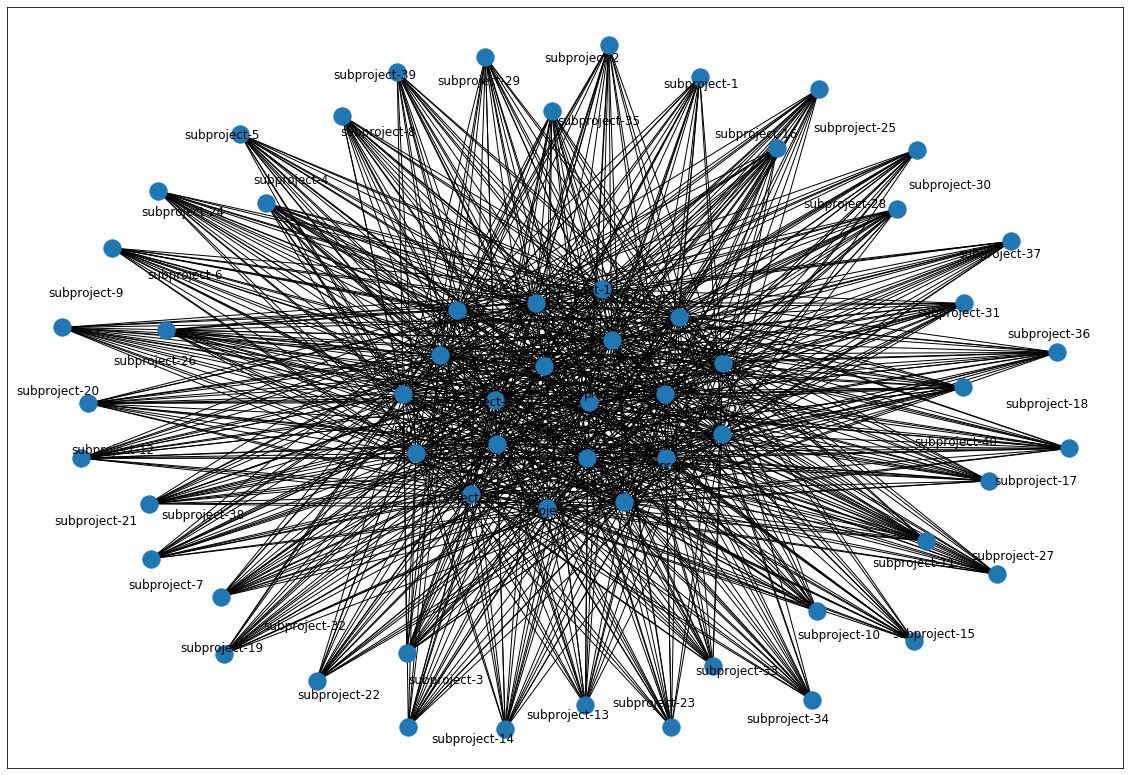

In [182]:
G=nx.from_pandas_edgelist(graph_df, 'project', 'subproject')

plt.figure(figsize = (20,14))
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos=pos)
nx.draw_networkx_edges(G, pos=pos)
labels=nx.draw_networkx_labels(G,pos=nx.spring_layout(G))

#### Subproject to Program List network graph

In [183]:
subproj_list = train_df['subproject'].to_list()
prog_list = train_df['program_title'].to_list()

graph_df_2 = train_df[['subproject', 'program_title']]
graph_df_2

subproject program_title
0     subproject-24    program-77
1     subproject-21    program-25
2      subproject-9    program-96
3      subproject-5    program-40
4     subproject-39    program-20
...             ...           ...
9995   subproject-7    program-62
9996  subproject-35     program-2
9997  subproject-18   program-111
9998  subproject-18    program-19
9999  subproject-19    program-84

[9986 rows x 2 columns]

Create the networkx object and plot

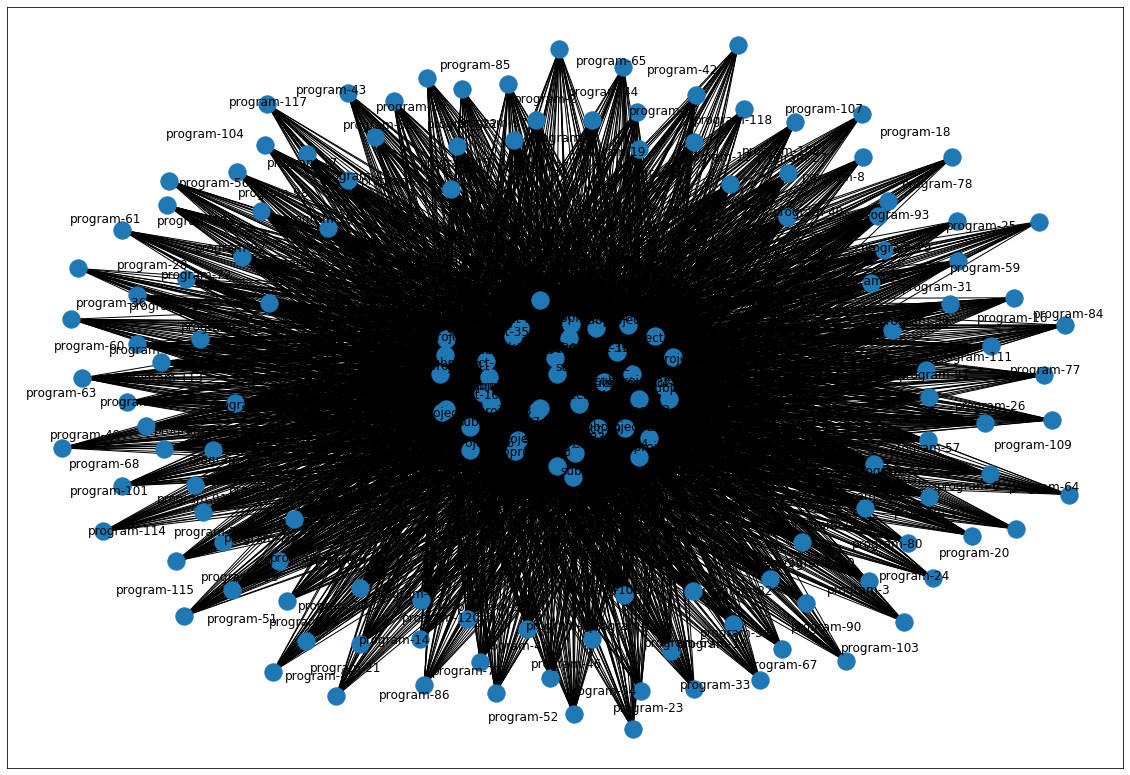

In [184]:
G=nx.from_pandas_edgelist(graph_df_2, 'subproject', 'program_title')

plt.figure(figsize = (20,14))
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos=pos)
nx.draw_networkx_edges(G, pos=pos)
labels=nx.draw_networkx_labels(G,pos=nx.spring_layout(G))

### Generate the sankey analysis 

Only retrieve the first 500 records

In [185]:
train_200 = train_df[:10].copy()

In [186]:
sum_df = train_200.groupby(['project', 'subproject', 'rca', 'program_title', 'yr2_oblig']).sum().reset_index()

fig = genSankey(sum_df,cat_cols=['project', 'subproject','rca', 'program_title'],value_cols='yr2_oblig',title='Sankey Analysis')
po.offline.plot(fig, validate=False)

'temp-plot.html'

In [187]:
train_df.head(10)

project     subproject     rca program_title  yr3_forecast  \
0  project-13  subproject-24  rca-75    program-77          1008   
1  project-19  subproject-21  rca-66    program-25         29634   
2  project-13   subproject-9  rca-36    program-96          5822   
3   project-8   subproject-5  rca-64    program-40         26009   
4   project-7  subproject-39  rca-20    program-20          8805   
5  project-20   subproject-5  rca-73    program-55         24264   
6   project-3  subproject-30   rca-2    program-62         27776   
7   project-8  subproject-30  rca-50    program-26          1349   
8   project-3  subproject-27  rca-16    program-52          5320   
9   project-3  subproject-14  rca-22    program-77         23013   

   yr2_forecast  yr1_forecast  yr0_plan  yr1_approp  yr2_oblig  \
0        842.56        994.02   1168.08     1146.55     951.09   
1      34273.85      39678.40  41418.87    40318.48   34710.73   
2       3066.16       2497.16   2504.83     2265.75    2042.90   
3      13651.07      11919.57  12082.16     8199.73    6776.43   
4       8134.39       8951.43  10483.53     7486.20    6075.57   
5      27215.38      24574.78  30646.26    19620.43   16776.38   
6      18529.27      21306.77  21367.28    20869.35   17357.29   
7        819.45        683.51    644.70      593.43     572.46   
8       3159.47       3334.97   3201.55     3420.48    2752.58   
9      20617.35      17700.93  14698.59    15011.83   12103.74   

                                          key  
0  project-13-subproject-24-rca-75-program-77  
1  project-19-subproject-21-rca-66-program-25  
2   project-13-subproject-9-rca-36-program-96  
3    project-8-subproject-5-rca-64-program-40  
4   project-7-subproject-39-rca-20-program-20  
5   project-20-subproject-5-rca-73-program-55  
6    project-3-subproject-30-rca-2-program-62  
7   project-8-subproject-30-rca-50-program-26  
8   project-3-subproject-27-rca-16-program-52  
9   project-3-subproject-14-rca-22-program-77

# PHASE 3: RANDOMIZE EXECUTION DATA 

Section to build out the test data and functions

Create a shallow copy of the completed 'train_df' dataframe in order to conducted stand alone financial execution data analysis

In [188]:
exe_df = train_df.copy()
exe_df.head(5)

project     subproject     rca program_title  yr3_forecast  \
0  project-13  subproject-24  rca-75    program-77          1008   
1  project-19  subproject-21  rca-66    program-25         29634   
2  project-13   subproject-9  rca-36    program-96          5822   
3   project-8   subproject-5  rca-64    program-40         26009   
4   project-7  subproject-39  rca-20    program-20          8805   

   yr2_forecast  yr1_forecast  yr0_plan  yr1_approp  yr2_oblig  \
0        842.56        994.02   1168.08     1146.55     951.09   
1      34273.85      39678.40  41418.87    40318.48   34710.73   
2       3066.16       2497.16   2504.83     2265.75    2042.90   
3      13651.07      11919.57  12082.16     8199.73    6776.43   
4       8134.39       8951.43  10483.53     7486.20    6075.57   

                                          key  
0  project-13-subproject-24-rca-75-program-77  
1  project-19-subproject-21-rca-66-program-25  
2   project-13-subproject-9-rca-36-program-96  
3    project-8-subproject-5-rca-64-program-40  
4   project-7-subproject-39-rca-20-program-20

Extract only the needed categorical columns

In [189]:
exe_slice = exe_df[['key','project','subproject','program_title','rca','yr0_plan']]
exe_slice = exe_slice.rename(columns={'yr0_plan': "usd_value"})
exe_slice.head(5)

key     project     subproject  \
0  project-13-subproject-24-rca-75-program-77  project-13  subproject-24   
1  project-19-subproject-21-rca-66-program-25  project-19  subproject-21   
2   project-13-subproject-9-rca-36-program-96  project-13   subproject-9   
3    project-8-subproject-5-rca-64-program-40   project-8   subproject-5   
4   project-7-subproject-39-rca-20-program-20   project-7  subproject-39   

  program_title     rca  usd_value  
0    program-77  rca-75    1168.08  
1    program-25  rca-66   41418.87  
2    program-96  rca-36    2504.83  
3    program-40  rca-64   12082.16  
4    program-20  rca-20   10483.53

Assign year ending values to the dataframe

In [190]:
exe_slice['month'] = '12'
exe_slice['year'] = '2019'
exe_slice.head(5)

key     project     subproject  \
0  project-13-subproject-24-rca-75-program-77  project-13  subproject-24   
1  project-19-subproject-21-rca-66-program-25  project-19  subproject-21   
2   project-13-subproject-9-rca-36-program-96  project-13   subproject-9   
3    project-8-subproject-5-rca-64-program-40   project-8   subproject-5   
4   project-7-subproject-39-rca-20-program-20   project-7  subproject-39   

  program_title     rca  usd_value month  year  
0    program-77  rca-75    1168.08    12  2019  
1    program-25  rca-66   41418.87    12  2019  
2    program-96  rca-36    2504.83    12  2019  
3    program-40  rca-64   12082.16    12  2019  
4    program-20  rca-20   10483.53    12  2019

Create a list of randomized obligated values for month ending 9-30-2019

In [191]:
df_len = len(exe_slice)
eoy_oblig = [random.uniform(0.9, 1.0) for x in range(df_len)]
eoy_oblig

[0.9823719200592188,
 0.9374640515033469,
 0.9167874846513752,
 0.9640463657708042,
 0.9273785408324624,
 0.9090463923851007,
 0.9469887434971714,
 0.9625029684240782,
 0.9544870370855575,
 0.9022215060866353,
 0.9135343227995443,
 0.9987387843849979,
 0.9307374690258654,
 0.99368649540297,
 0.9149124828062463,
 0.9242666512576079,
 0.9860402719529452,
 0.9725216359358176,
 0.9243146095975405,
 0.9793570722832726,
 0.9310846119780402,
 0.9429011536742572,
 0.9520280344769936,
 0.9826104935193147,
 0.936400360141656,
 0.9697478705164052,
 0.9316940037348591,
 0.9726208866215689,
 0.9643984704425718,
 0.9595405426089862,
 0.9722148968254116,
 0.9677801011396743,
 0.911752773052168,
 0.982893419928799,
 0.9606167578433348,
 0.9957552441537032,
 0.9502447446596698,
 0.9356879448145083,
 0.9870395460580343,
 0.9982202093201011,
 0.9042544936045388,
 0.9981130047701453,
 0.9313314316566044,
 0.9975243102346382,
 0.9015949439630846,
 0.9247138541083453,
 0.9664409454749008,
 0.900830558981399

Calculate the end of year obligation values

In [192]:
exe_slice['oblig'] = exe_slice['usd_value'] * eoy_oblig
exe_slice

key     project     subproject  \
0      project-13-subproject-24-rca-75-program-77  project-13  subproject-24   
1      project-19-subproject-21-rca-66-program-25  project-19  subproject-21   
2       project-13-subproject-9-rca-36-program-96  project-13   subproject-9   
3        project-8-subproject-5-rca-64-program-40   project-8   subproject-5   
4       project-7-subproject-39-rca-20-program-20   project-7  subproject-39   
...                                           ...         ...            ...   
9995    project-11-subproject-7-rca-73-program-62  project-11   subproject-7   
9996    project-14-subproject-35-rca-31-program-2  project-14  subproject-35   
9997  project-12-subproject-18-rca-74-program-111  project-12  subproject-18   
9998    project-4-subproject-18-rca-60-program-19   project-4  subproject-18   
9999    project-9-subproject-19-rca-30-program-84   project-9  subproject-19   

     program_title     rca  usd_value month  year         oblig  
0       program-77  rca-75    1168.08    12  2019   1147.488992  
1       program-25  rca-66   41418.87    12  2019  38828.701679  
2       program-96  rca-36    2504.83    12  2019   2296.396795  
3       program-40  rca-64   12082.16    12  2019  11647.762439  
4       program-20  rca-20   10483.53    12  2019   9722.200754  
...            ...     ...        ...   ...   ...           ...  
9995    program-62  rca-73    9775.50    12  2019   9698.225244  
9996     program-2  rca-31    1184.51    12  2019   1129.322182  
9997   program-111  rca-74    9243.60    12  2019   8455.852590  
9998    program-19  rca-60   27388.30    12  2019  26365.612385  
9999    program-84  rca-30    2336.71    12  2019   2145.850825  

[9986 rows x 9 columns]

Create the execution burn rate percentages

In [193]:
eoy_exe = [random.uniform(0.6, .9) for x in range(df_len)]
eoy_exe

[0.8852317246040778,
 0.7015146452686949,
 0.740987679184246,
 0.6590799941730809,
 0.6025597373419361,
 0.6684741820982998,
 0.8728311850690915,
 0.7330165471868569,
 0.8997916454626437,
 0.7481301243949424,
 0.8782781562595257,
 0.7833319602039626,
 0.6360280526140585,
 0.7618656588532158,
 0.8416287197486945,
 0.6913690859721622,
 0.8848566929174413,
 0.6057625424081164,
 0.7089529121279312,
 0.8999062865688428,
 0.8582614652122642,
 0.6824525930382364,
 0.8147725088822758,
 0.748191081856372,
 0.6894310214679212,
 0.888931099828857,
 0.7193359297040169,
 0.6433805608479699,
 0.6984568405261089,
 0.6927980081976224,
 0.7370351228704205,
 0.7099559092747018,
 0.8060657547243646,
 0.8072215817894208,
 0.6909151900600904,
 0.7814951412179467,
 0.731998023804606,
 0.8069177907412705,
 0.7085806049642153,
 0.769831968002606,
 0.7901233201096187,
 0.8424298461175181,
 0.6385266789371085,
 0.7279201643183044,
 0.6328393809617505,
 0.7377674862981114,
 0.8692412725422816,
 0.823718674724329

Calculate the obligation and execution rates at the month level

In [194]:
exe_slice['total_authority'] = exe_slice['oblig']
exe_slice['executed'] = exe_slice['oblig'] * eoy_exe
exe_slice[:10]

key     project     subproject  \
0  project-13-subproject-24-rca-75-program-77  project-13  subproject-24   
1  project-19-subproject-21-rca-66-program-25  project-19  subproject-21   
2   project-13-subproject-9-rca-36-program-96  project-13   subproject-9   
3    project-8-subproject-5-rca-64-program-40   project-8   subproject-5   
4   project-7-subproject-39-rca-20-program-20   project-7  subproject-39   
5   project-20-subproject-5-rca-73-program-55  project-20   subproject-5   
6    project-3-subproject-30-rca-2-program-62   project-3  subproject-30   
7   project-8-subproject-30-rca-50-program-26   project-8  subproject-30   
8   project-3-subproject-27-rca-16-program-52   project-3  subproject-27   
9   project-3-subproject-14-rca-22-program-77   project-3  subproject-14   

  program_title     rca  usd_value month  year         oblig  total_authority  \
0    program-77  rca-75    1168.08    12  2019   1147.488992      1147.488992   
1    program-25  rca-66   41418.87    12  2019  38828.701679     38828.701679   
2    program-96  rca-36    2504.83    12  2019   2296.396795      2296.396795   
3    program-40  rca-64   12082.16    12  2019  11647.762439     11647.762439   
4    program-20  rca-20   10483.53    12  2019   9722.200754      9722.200754   
5    program-55  rca-73   30646.26    12  2019  27858.872093     27858.872093   
6    program-62   rca-2   21367.28    12  2019  20234.573639     20234.573639   
7    program-26  rca-50     644.70    12  2019    620.525664       620.525664   
8    program-52  rca-16    3201.55    12  2019   3055.837974      3055.837974   
9    program-77  rca-22   14698.59    12  2019  13261.384007     13261.384007   

       executed  
0   1015.793660  
1  27238.902885  
2   1701.601732  
3   7676.807200  
4   5858.206733  
5  18622.936737  
6  17661.366889  
7    454.855579  
8   2749.617479  
9   9921.240867

Create a list of 'key' values

In [195]:
key_list = list(exe_slice['key'])
key_list

['project-13-subproject-24-rca-75-program-77',
 'project-19-subproject-21-rca-66-program-25',
 'project-13-subproject-9-rca-36-program-96',
 'project-8-subproject-5-rca-64-program-40',
 'project-7-subproject-39-rca-20-program-20',
 'project-20-subproject-5-rca-73-program-55',
 'project-3-subproject-30-rca-2-program-62',
 'project-8-subproject-30-rca-50-program-26',
 'project-3-subproject-27-rca-16-program-52',
 'project-3-subproject-14-rca-22-program-77',
 'project-11-subproject-9-rca-22-program-16',
 'project-17-subproject-14-rca-54-program-117',
 'project-19-subproject-6-rca-26-program-47',
 'project-20-subproject-7-rca-39-program-66',
 'project-13-subproject-27-rca-67-program-76',
 'project-16-subproject-25-rca-16-program-11',
 'project-7-subproject-36-rca-34-program-33',
 'project-9-subproject-3-rca-80-program-109',
 'project-3-subproject-34-rca-37-program-64',
 'project-5-subproject-4-rca-56-program-81',
 'project-15-subproject-15-rca-48-program-88',
 'project-20-subproject-17-rca

In [196]:
exe_slice.dtypes

key                 object
project             object
subproject          object
program_title       object
rca                 object
usd_value          float64
month               object
year                object
oblig              float64
total_authority    float64
executed           float64
dtype: object

## Test one key for the timeseries for loop

Extract the first value from the master dataframe

In [197]:
temp = exe_slice[:1]
temp

key     project     subproject  \
0  project-13-subproject-24-rca-75-program-77  project-13  subproject-24   

  program_title     rca  usd_value month  year        oblig  total_authority  \
0    program-77  rca-75    1168.08    12  2019  1147.488992      1147.488992   

     executed  
0  1015.79366

Generate a dataframe with the newly added columns:
    
    1. executed - column to store executed EOM transactions
    2. total_authority - column to store total authority values for a given key (i.e. 'project-17-subproject-25-rca-43-program-28')

In [198]:
for month in range(11): # iterate through the remaining 11 months of the calendar year
    
    print("top of the loop")
    display(temp)
    current_month = 11 - month
    print("Current month: ", current_month)
    
    forward_month = int(current_month) + 1
    print("Forward month: ", forward_month)
    
    converted_month = str(forward_month)
    print("Converted month: ", converted_month)
    
    month_cond = temp['month'].str.startswith(converted_month, na=False) 

    temp_row = temp[month_cond]
    display(temp_row)
    #display(temp_row.iat[0,0])

    key_val = temp.iat[month,0]
    print(key_val)
    
    # assign the project value
    project_val = temp.iat[month,1]
    print(project_val)
    
    # assign the subproject value
    subproject_val = temp.iat[month,2]
    print(subproject_val)
    
    # assign the program value
    program_val = temp.iat[month,3]
    print(program_val)
    
    # assign the rca value
    rca_val = temp.iat[month,4]
    print(rca_val)
    
    # assign the forward month obligation value
    forward_oblig_val = temp.iat[month,8]
    print(forward_oblig_val)

    # assign the current month obligation value
    current_oblig_val = forward_oblig_val * .8
    print(current_oblig_val)
    
    # assign the forward month execution value
    forward_exe_val = temp.iat[month,10]
    print(forward_exe_val)

    # assign the current month execution value
    current_exe_val = forward_oblig_val * .7
    print(current_exe_val)
    
    ta_val = temp.iat[month,9]
    print(ta_val)

    usd_val = 0
    temp = temp.append(pd.DataFrame([[key_val,project_val,subproject_val,rca_val,program_val, usd_val, current_month, '2019', current_oblig_val,ta_val, current_exe_val]], columns=temp.columns))
    print('\nAdded row\n')

    

top of the loop


key     project     subproject  \
0  project-13-subproject-24-rca-75-program-77  project-13  subproject-24   

  program_title     rca  usd_value month  year        oblig  total_authority  \
0    program-77  rca-75    1168.08    12  2019  1147.488992      1147.488992   

     executed  
0  1015.79366

Current month:  11
Forward month:  12
Converted month:  12


key     project     subproject  \
0  project-13-subproject-24-rca-75-program-77  project-13  subproject-24   

  program_title     rca  usd_value month  year        oblig  total_authority  \
0    program-77  rca-75    1168.08    12  2019  1147.488992      1147.488992   

     executed  
0  1015.79366

project-13-subproject-24-rca-75-program-77
project-13
subproject-24
program-77
rca-75
1147.4889923827723
917.9911939062179
1015.793659691197
803.2422946679405
1147.4889923827723

Added row

top of the loop


key     project     subproject  \
0  project-13-subproject-24-rca-75-program-77  project-13  subproject-24   
0  project-13-subproject-24-rca-75-program-77  project-13  subproject-24   

  program_title         rca  usd_value month  year        oblig  \
0    program-77      rca-75    1168.08    12  2019  1147.488992   
0        rca-75  program-77       0.00    11  2019   917.991194   

   total_authority     executed  
0      1147.488992  1015.793660  
0      1147.488992   803.242295

Current month:  10
Forward month:  11
Converted month:  11


Empty DataFrame
Columns: [key, project, subproject, program_title, rca, usd_value, month, year, oblig, total_authority, executed]
Index: []

project-13-subproject-24-rca-75-program-77
project-13
subproject-24
rca-75
program-77
917.9911939062179
734.3929551249744
803.2422946679405
642.5938357343524
1147.4889923827723

Added row

top of the loop


key     project     subproject  \
0  project-13-subproject-24-rca-75-program-77  project-13  subproject-24   
0  project-13-subproject-24-rca-75-program-77  project-13  subproject-24   
0  project-13-subproject-24-rca-75-program-77  project-13  subproject-24   

  program_title         rca  usd_value month  year        oblig  \
0    program-77      rca-75    1168.08    12  2019  1147.488992   
0        rca-75  program-77       0.00    11  2019   917.991194   
0    program-77      rca-75       0.00    10  2019   734.392955   

   total_authority     executed  
0      1147.488992  1015.793660  
0      1147.488992   803.242295  
0      1147.488992   642.593836

Current month:  9
Forward month:  10
Converted month:  10


Empty DataFrame
Columns: [key, project, subproject, program_title, rca, usd_value, month, year, oblig, total_authority, executed]
Index: []

project-13-subproject-24-rca-75-program-77
project-13
subproject-24
program-77
rca-75
734.3929551249744
587.5143640999795
642.5938357343524
514.0750685874821
1147.4889923827723

Added row

top of the loop


key     project     subproject  \
0  project-13-subproject-24-rca-75-program-77  project-13  subproject-24   
0  project-13-subproject-24-rca-75-program-77  project-13  subproject-24   
0  project-13-subproject-24-rca-75-program-77  project-13  subproject-24   
0  project-13-subproject-24-rca-75-program-77  project-13  subproject-24   

  program_title         rca  usd_value month  year        oblig  \
0    program-77      rca-75    1168.08    12  2019  1147.488992   
0        rca-75  program-77       0.00    11  2019   917.991194   
0    program-77      rca-75       0.00    10  2019   734.392955   
0        rca-75  program-77       0.00     9  2019   587.514364   

   total_authority     executed  
0      1147.488992  1015.793660  
0      1147.488992   803.242295  
0      1147.488992   642.593836  
0      1147.488992   514.075069

Current month:  8
Forward month:  9
Converted month:  9


Empty DataFrame
Columns: [key, project, subproject, program_title, rca, usd_value, month, year, oblig, total_authority, executed]
Index: []

project-13-subproject-24-rca-75-program-77
project-13
subproject-24
rca-75
program-77
587.5143640999795
470.0114912799836
514.0750685874821
411.26005486998565
1147.4889923827723

Added row

top of the loop


key     project     subproject  \
0  project-13-subproject-24-rca-75-program-77  project-13  subproject-24   
0  project-13-subproject-24-rca-75-program-77  project-13  subproject-24   
0  project-13-subproject-24-rca-75-program-77  project-13  subproject-24   
0  project-13-subproject-24-rca-75-program-77  project-13  subproject-24   
0  project-13-subproject-24-rca-75-program-77  project-13  subproject-24   

  program_title         rca  usd_value month  year        oblig  \
0    program-77      rca-75    1168.08    12  2019  1147.488992   
0        rca-75  program-77       0.00    11  2019   917.991194   
0    program-77      rca-75       0.00    10  2019   734.392955   
0        rca-75  program-77       0.00     9  2019   587.514364   
0    program-77      rca-75       0.00     8  2019   470.011491   

   total_authority     executed  
0      1147.488992  1015.793660  
0      1147.488992   803.242295  
0      1147.488992   642.593836  
0      1147.488992   514.075069  
0      1147.488992   411.260055

Current month:  7
Forward month:  8
Converted month:  8


Empty DataFrame
Columns: [key, project, subproject, program_title, rca, usd_value, month, year, oblig, total_authority, executed]
Index: []

project-13-subproject-24-rca-75-program-77
project-13
subproject-24
program-77
rca-75
470.0114912799836
376.0091930239869
411.26005486998565
329.0080438959885
1147.4889923827723

Added row

top of the loop


key     project     subproject  \
0  project-13-subproject-24-rca-75-program-77  project-13  subproject-24   
0  project-13-subproject-24-rca-75-program-77  project-13  subproject-24   
0  project-13-subproject-24-rca-75-program-77  project-13  subproject-24   
0  project-13-subproject-24-rca-75-program-77  project-13  subproject-24   
0  project-13-subproject-24-rca-75-program-77  project-13  subproject-24   
0  project-13-subproject-24-rca-75-program-77  project-13  subproject-24   

  program_title         rca  usd_value month  year        oblig  \
0    program-77      rca-75    1168.08    12  2019  1147.488992   
0        rca-75  program-77       0.00    11  2019   917.991194   
0    program-77      rca-75       0.00    10  2019   734.392955   
0        rca-75  program-77       0.00     9  2019   587.514364   
0    program-77      rca-75       0.00     8  2019   470.011491   
0        rca-75  program-77       0.00     7  2019   376.009193   

   total_authority     executed  
0      1147.488992  1015.793660  
0      1147.488992   803.242295  
0      1147.488992   642.593836  
0      1147.488992   514.075069  
0      1147.488992   411.260055  
0      1147.488992   329.008044

Current month:  6
Forward month:  7
Converted month:  7


Empty DataFrame
Columns: [key, project, subproject, program_title, rca, usd_value, month, year, oblig, total_authority, executed]
Index: []

project-13-subproject-24-rca-75-program-77
project-13
subproject-24
rca-75
program-77
376.0091930239869
300.8073544191895
329.0080438959885
263.20643511679083
1147.4889923827723

Added row

top of the loop


key     project     subproject  \
0  project-13-subproject-24-rca-75-program-77  project-13  subproject-24   
0  project-13-subproject-24-rca-75-program-77  project-13  subproject-24   
0  project-13-subproject-24-rca-75-program-77  project-13  subproject-24   
0  project-13-subproject-24-rca-75-program-77  project-13  subproject-24   
0  project-13-subproject-24-rca-75-program-77  project-13  subproject-24   
0  project-13-subproject-24-rca-75-program-77  project-13  subproject-24   
0  project-13-subproject-24-rca-75-program-77  project-13  subproject-24   

  program_title         rca  usd_value month  year        oblig  \
0    program-77      rca-75    1168.08    12  2019  1147.488992   
0        rca-75  program-77       0.00    11  2019   917.991194   
0    program-77      rca-75       0.00    10  2019   734.392955   
0        rca-75  program-77       0.00     9  2019   587.514364   
0    program-77      rca-75       0.00     8  2019   470.011491   
0        rca-75  program-77       0.00     7  2019   376.009193   
0    program-77      rca-75       0.00     6  2019   300.807354   

   total_authority     executed  
0      1147.488992  1015.793660  
0      1147.488992   803.242295  
0      1147.488992   642.593836  
0      1147.488992   514.075069  
0      1147.488992   411.260055  
0      1147.488992   329.008044  
0      1147.488992   263.206435

Current month:  5
Forward month:  6
Converted month:  6


Empty DataFrame
Columns: [key, project, subproject, program_title, rca, usd_value, month, year, oblig, total_authority, executed]
Index: []

project-13-subproject-24-rca-75-program-77
project-13
subproject-24
program-77
rca-75
300.8073544191895
240.6458835353516
263.20643511679083
210.56514809343264
1147.4889923827723

Added row

top of the loop


key     project     subproject  \
0  project-13-subproject-24-rca-75-program-77  project-13  subproject-24   
0  project-13-subproject-24-rca-75-program-77  project-13  subproject-24   
0  project-13-subproject-24-rca-75-program-77  project-13  subproject-24   
0  project-13-subproject-24-rca-75-program-77  project-13  subproject-24   
0  project-13-subproject-24-rca-75-program-77  project-13  subproject-24   
0  project-13-subproject-24-rca-75-program-77  project-13  subproject-24   
0  project-13-subproject-24-rca-75-program-77  project-13  subproject-24   
0  project-13-subproject-24-rca-75-program-77  project-13  subproject-24   

  program_title         rca  usd_value month  year        oblig  \
0    program-77      rca-75    1168.08    12  2019  1147.488992   
0        rca-75  program-77       0.00    11  2019   917.991194   
0    program-77      rca-75       0.00    10  2019   734.392955   
0        rca-75  program-77       0.00     9  2019   587.514364   
0    program-77      rca-75       0.00     8  2019   470.011491   
0        rca-75  program-77       0.00     7  2019   376.009193   
0    program-77      rca-75       0.00     6  2019   300.807354   
0        rca-75  program-77       0.00     5  2019   240.645884   

   total_authority     executed  
0      1147.488992  1015.793660  
0      1147.488992   803.242295  
0      1147.488992   642.593836  
0      1147.488992   514.075069  
0      1147.488992   411.260055  
0      1147.488992   329.008044  
0      1147.488992   263.206435  
0      1147.488992   210.565148

Current month:  4
Forward month:  5
Converted month:  5


Empty DataFrame
Columns: [key, project, subproject, program_title, rca, usd_value, month, year, oblig, total_authority, executed]
Index: []

project-13-subproject-24-rca-75-program-77
project-13
subproject-24
rca-75
program-77
240.6458835353516
192.5167068282813
210.56514809343264
168.4521184747461
1147.4889923827723

Added row

top of the loop


key     project     subproject  \
0  project-13-subproject-24-rca-75-program-77  project-13  subproject-24   
0  project-13-subproject-24-rca-75-program-77  project-13  subproject-24   
0  project-13-subproject-24-rca-75-program-77  project-13  subproject-24   
0  project-13-subproject-24-rca-75-program-77  project-13  subproject-24   
0  project-13-subproject-24-rca-75-program-77  project-13  subproject-24   
0  project-13-subproject-24-rca-75-program-77  project-13  subproject-24   
0  project-13-subproject-24-rca-75-program-77  project-13  subproject-24   
0  project-13-subproject-24-rca-75-program-77  project-13  subproject-24   
0  project-13-subproject-24-rca-75-program-77  project-13  subproject-24   

  program_title         rca  usd_value month  year        oblig  \
0    program-77      rca-75    1168.08    12  2019  1147.488992   
0        rca-75  program-77       0.00    11  2019   917.991194   
0    program-77      rca-75       0.00    10  2019   734.392955   
0        rca-75  program-77       0.00     9  2019   587.514364   
0    program-77      rca-75       0.00     8  2019   470.011491   
0        rca-75  program-77       0.00     7  2019   376.009193   
0    program-77      rca-75       0.00     6  2019   300.807354   
0        rca-75  program-77       0.00     5  2019   240.645884   
0    program-77      rca-75       0.00     4  2019   192.516707   

   total_authority     executed  
0      1147.488992  1015.793660  
0      1147.488992   803.242295  
0      1147.488992   642.593836  
0      1147.488992   514.075069  
0      1147.488992   411.260055  
0      1147.488992   329.008044  
0      1147.488992   263.206435  
0      1147.488992   210.565148  
0      1147.488992   168.452118

Current month:  3
Forward month:  4
Converted month:  4


Empty DataFrame
Columns: [key, project, subproject, program_title, rca, usd_value, month, year, oblig, total_authority, executed]
Index: []

project-13-subproject-24-rca-75-program-77
project-13
subproject-24
program-77
rca-75
192.5167068282813
154.01336546262505
168.4521184747461
134.7616947797969
1147.4889923827723

Added row

top of the loop


key     project     subproject  \
0  project-13-subproject-24-rca-75-program-77  project-13  subproject-24   
0  project-13-subproject-24-rca-75-program-77  project-13  subproject-24   
0  project-13-subproject-24-rca-75-program-77  project-13  subproject-24   
0  project-13-subproject-24-rca-75-program-77  project-13  subproject-24   
0  project-13-subproject-24-rca-75-program-77  project-13  subproject-24   
0  project-13-subproject-24-rca-75-program-77  project-13  subproject-24   
0  project-13-subproject-24-rca-75-program-77  project-13  subproject-24   
0  project-13-subproject-24-rca-75-program-77  project-13  subproject-24   
0  project-13-subproject-24-rca-75-program-77  project-13  subproject-24   
0  project-13-subproject-24-rca-75-program-77  project-13  subproject-24   

  program_title         rca  usd_value month  year        oblig  \
0    program-77      rca-75    1168.08    12  2019  1147.488992   
0        rca-75  program-77       0.00    11  2019   917.991194   
0    program-77      rca-75       0.00    10  2019   734.392955   
0        rca-75  program-77       0.00     9  2019   587.514364   
0    program-77      rca-75       0.00     8  2019   470.011491   
0        rca-75  program-77       0.00     7  2019   376.009193   
0    program-77      rca-75       0.00     6  2019   300.807354   
0        rca-75  program-77       0.00     5  2019   240.645884   
0    program-77      rca-75       0.00     4  2019   192.516707   
0        rca-75  program-77       0.00     3  2019   154.013365   

   total_authority     executed  
0      1147.488992  1015.793660  
0      1147.488992   803.242295  
0      1147.488992   642.593836  
0      1147.488992   514.075069  
0      1147.488992   411.260055  
0      1147.488992   329.008044  
0      1147.488992   263.206435  
0      1147.488992   210.565148  
0      1147.488992   168.452118  
0      1147.488992   134.761695

Current month:  2
Forward month:  3
Converted month:  3


Empty DataFrame
Columns: [key, project, subproject, program_title, rca, usd_value, month, year, oblig, total_authority, executed]
Index: []

project-13-subproject-24-rca-75-program-77
project-13
subproject-24
rca-75
program-77
154.01336546262505
123.21069237010005
134.7616947797969
107.80935582383752
1147.4889923827723

Added row

top of the loop


key     project     subproject  \
0  project-13-subproject-24-rca-75-program-77  project-13  subproject-24   
0  project-13-subproject-24-rca-75-program-77  project-13  subproject-24   
0  project-13-subproject-24-rca-75-program-77  project-13  subproject-24   
0  project-13-subproject-24-rca-75-program-77  project-13  subproject-24   
0  project-13-subproject-24-rca-75-program-77  project-13  subproject-24   
0  project-13-subproject-24-rca-75-program-77  project-13  subproject-24   
0  project-13-subproject-24-rca-75-program-77  project-13  subproject-24   
0  project-13-subproject-24-rca-75-program-77  project-13  subproject-24   
0  project-13-subproject-24-rca-75-program-77  project-13  subproject-24   
0  project-13-subproject-24-rca-75-program-77  project-13  subproject-24   
0  project-13-subproject-24-rca-75-program-77  project-13  subproject-24   

  program_title         rca  usd_value month  year        oblig  \
0    program-77      rca-75    1168.08    12  2019  1147.488992   
0        rca-75  program-77       0.00    11  2019   917.991194   
0    program-77      rca-75       0.00    10  2019   734.392955   
0        rca-75  program-77       0.00     9  2019   587.514364   
0    program-77      rca-75       0.00     8  2019   470.011491   
0        rca-75  program-77       0.00     7  2019   376.009193   
0    program-77      rca-75       0.00     6  2019   300.807354   
0        rca-75  program-77       0.00     5  2019   240.645884   
0    program-77      rca-75       0.00     4  2019   192.516707   
0        rca-75  program-77       0.00     3  2019   154.013365   
0    program-77      rca-75       0.00     2  2019   123.210692   

   total_authority     executed  
0      1147.488992  1015.793660  
0      1147.488992   803.242295  
0      1147.488992   642.593836  
0      1147.488992   514.075069  
0      1147.488992   411.260055  
0      1147.488992   329.008044  
0      1147.488992   263.206435  
0      1147.488992   210.565148  
0      1147.488992   168.452118  
0      1147.488992   134.761695  
0      1147.488992   107.809356

Current month:  1
Forward month:  2
Converted month:  2


Empty DataFrame
Columns: [key, project, subproject, program_title, rca, usd_value, month, year, oblig, total_authority, executed]
Index: []

project-13-subproject-24-rca-75-program-77
project-13
subproject-24
program-77
rca-75
123.21069237010005
98.56855389608005
107.80935582383752
86.24748465907003
1147.4889923827723

Added row



Calculate utilization percentages

In [199]:
temp['oblig_ta_rate'] = temp['oblig'] / temp['total_authority']
temp['exe_ta_rate'] = temp['executed'] / temp['total_authority']
temp['exe_oblig_rate'] = temp['executed'] / temp['oblig']

temp

key     project     subproject  \
0  project-13-subproject-24-rca-75-program-77  project-13  subproject-24   
0  project-13-subproject-24-rca-75-program-77  project-13  subproject-24   
0  project-13-subproject-24-rca-75-program-77  project-13  subproject-24   
0  project-13-subproject-24-rca-75-program-77  project-13  subproject-24   
0  project-13-subproject-24-rca-75-program-77  project-13  subproject-24   
0  project-13-subproject-24-rca-75-program-77  project-13  subproject-24   
0  project-13-subproject-24-rca-75-program-77  project-13  subproject-24   
0  project-13-subproject-24-rca-75-program-77  project-13  subproject-24   
0  project-13-subproject-24-rca-75-program-77  project-13  subproject-24   
0  project-13-subproject-24-rca-75-program-77  project-13  subproject-24   
0  project-13-subproject-24-rca-75-program-77  project-13  subproject-24   
0  project-13-subproject-24-rca-75-program-77  project-13  subproject-24   

  program_title         rca  usd_value month  year        oblig  \
0    program-77      rca-75    1168.08    12  2019  1147.488992   
0        rca-75  program-77       0.00    11  2019   917.991194   
0    program-77      rca-75       0.00    10  2019   734.392955   
0        rca-75  program-77       0.00     9  2019   587.514364   
0    program-77      rca-75       0.00     8  2019   470.011491   
0        rca-75  program-77       0.00     7  2019   376.009193   
0    program-77      rca-75       0.00     6  2019   300.807354   
0        rca-75  program-77       0.00     5  2019   240.645884   
0    program-77      rca-75       0.00     4  2019   192.516707   
0        rca-75  program-77       0.00     3  2019   154.013365   
0    program-77      rca-75       0.00     2  2019   123.210692   
0        rca-75  program-77       0.00     1  2019    98.568554   

   total_authority     executed  oblig_ta_rate  exe_ta_rate  exe_oblig_rate  
0      1147.488992  1015.793660       1.000000     0.885232        0.885232  
0      1147.488992   803.242295       0.800000     0.700000        0.875000  
0      1147.488992   642.593836       0.640000     0.560000        0.875000  
0      1147.488992   514.075069       0.512000     0.448000        0.875000  
0      1147.488992   411.260055       0.409600     0.358400        0.875000  
0      1147.488992   329.008044       0.327680     0.286720        0.875000  
0      1147.488992   263.206435       0.262144     0.229376        0.875000  
0      1147.488992   210.565148       0.209715     0.183501        0.875000  
0      1147.488992   168.452118       0.167772     0.146801        0.875000  
0      1147.488992   134.761695       0.134218     0.117441        0.875000  
0      1147.488992   107.809356       0.107374     0.093952        0.875000  
0      1147.488992    86.247485       0.085899     0.075162        0.875000

Add month name as a stand alone column

In [200]:
conditions = [
    (temp['month'] == 12),
    (temp['month'] == 11),
    (temp['month'] == 10),
    (temp['month'] == 9),
    (temp['month'] == 8),
    (temp['month'] == 7),
    (temp['month'] == 6),
    (temp['month'] == 5),
    (temp['month'] == 4),
    (temp['month'] == 3),
    (temp['month'] == 2),
    (temp['month'] == 1),]
choices = ['September', 'August', 'July', 'June', 'May', 'April', 'March', 'February', 'January', 'December', 'November', 'October']
temp['month_name'] = np.select(conditions, choices, default='September')

Melt the quant columns to two columns, 'variable' and 'value'

In [201]:
plot_temp = temp[['month', 'month_name', 'oblig', 'total_authority', 'executed']].reset_index()
df_waterfall = pd.melt(plot_temp, id_vars=["month_name", 'month'], value_vars=["oblig", "total_authority", 'executed'])
df_waterfall[:10]

month_name month variable        value
0  September    12    oblig  1147.488992
1     August    11    oblig   917.991194
2       July    10    oblig   734.392955
3       June     9    oblig   587.514364
4        May     8    oblig   470.011491
5      April     7    oblig   376.009193
6      March     6    oblig   300.807354
7   February     5    oblig   240.645884
8    January     4    oblig   192.516707
9   December     3    oblig   154.013365

Sort the values by month and variable, descending

In [202]:
sorted_df = df_waterfall.sort_values(by=['month', 'variable'])
sorted_df[:10]

month_name month         variable        value
35    October     1         executed    86.247485
11    October     1            oblig    98.568554
23    October     1  total_authority  1147.488992
34   November     2         executed   107.809356
10   November     2            oblig   123.210692
22   November     2  total_authority  1147.488992
33   December     3         executed   134.761695
9    December     3            oblig   154.013365
21   December     3  total_authority  1147.488992
32    January     4         executed   168.452118

Create the plotly chart

In [203]:

fig = px.bar(sorted_df, y='value', x='month_name', color = 'variable', title = "Execution, Obligation, and Total Authority Summary")
fig.update_layout(barmode='group')
fig.show()

### Visualize the utilization percentages at the RCA level

In [204]:
plot_temp = temp[['month', 'oblig_ta_rate', 'exe_ta_rate', 'exe_oblig_rate']].reset_index()
df_util = pd.melt(plot_temp, id_vars=["month"], value_vars=['oblig_ta_rate', 'exe_ta_rate', 'exe_oblig_rate'])
df_util[:10]

month       variable     value
0    12  oblig_ta_rate  1.000000
1    11  oblig_ta_rate  0.800000
2    10  oblig_ta_rate  0.640000
3     9  oblig_ta_rate  0.512000
4     8  oblig_ta_rate  0.409600
5     7  oblig_ta_rate  0.327680
6     6  oblig_ta_rate  0.262144
7     5  oblig_ta_rate  0.209715
8     4  oblig_ta_rate  0.167772
9     3  oblig_ta_rate  0.134218

In [205]:
sorted_util = df_util.sort_values(by=['month', 'variable'])
sorted_util[:10]

month        variable     value
35     1  exe_oblig_rate  0.875000
23     1     exe_ta_rate  0.075162
11     1   oblig_ta_rate  0.085899
34     2  exe_oblig_rate  0.875000
22     2     exe_ta_rate  0.093952
10     2   oblig_ta_rate  0.107374
33     3  exe_oblig_rate  0.875000
21     3     exe_ta_rate  0.117441
9      3   oblig_ta_rate  0.134218
32     4  exe_oblig_rate  0.875000

Plot the utilization rates for the given key

In [206]:
fig = px.line(sorted_util, y='value', x='month', color = 'variable', title = "Utilization Rate Summary for 'project-17-subproject-25-program-28-rca-43'", width=1200, height=700)

fig.update_layout(barmode='group')
fig.data[0].update(mode='markers+lines')
fig.data[1].update(mode='markers+lines')
fig.data[2].update(mode='markers+lines')

fig.show()

## Consolidated timeseries generated loop

In [138]:
temp2 = exe_slice.copy()
temp2[:5]

key     project     subproject  \
0  project-13-subproject-24-rca-75program-77  project-13  subproject-24   
1  project-19-subproject-21-rca-66program-25  project-19  subproject-21   
2   project-13-subproject-9-rca-36program-96  project-13   subproject-9   
3    project-8-subproject-5-rca-64program-40   project-8   subproject-5   
4   project-7-subproject-39-rca-20program-20   project-7  subproject-39   

  program_title     rca  usd_value month  year         oblig  total_authority  \
0    program-77  rca-75    1168.08    12  2019   1114.773125      1114.773125   
1    program-25  rca-66   41418.87    12  2019  39752.682044     39752.682044   
2    program-96  rca-36    2504.83    12  2019   2365.157347      2365.157347   
3    program-40  rca-64   12082.16    12  2019  10911.630806     10911.630806   
4    program-20  rca-20   10483.53    12  2019   9946.012230      9946.012230   

       executed  
0    674.469622  
1  26281.294848  
2   2102.952293  
3   7190.124105  
4   7855.838475

# PHASE 4: EXPORT DATA

In [139]:
train_df.head(10)

project     subproject     rca program_title  yr3_forecast  \
0  project-13  subproject-24  rca-75    program-77          1008   
1  project-19  subproject-21  rca-66    program-25         29634   
2  project-13   subproject-9  rca-36    program-96          5822   
3   project-8   subproject-5  rca-64    program-40         26009   
4   project-7  subproject-39  rca-20    program-20          8805   
5  project-20   subproject-5  rca-73    program-55         24264   
6   project-3  subproject-30   rca-2    program-62         27776   
7   project-8  subproject-30  rca-50    program-26          1349   
8   project-3  subproject-27  rca-16    program-52          5320   
9   project-3  subproject-14  rca-22    program-77         23013   

   yr2_forecast  yr1_forecast  yr0_plan  yr1_approp  yr2_oblig  \
0        842.56        994.02   1168.08     1146.55     951.09   
1      34273.85      39678.40  41418.87    40318.48   34710.73   
2       3066.16       2497.16   2504.83     2265.75    2042.90   
3      13651.07      11919.57  12082.16     8199.73    6776.43   
4       8134.39       8951.43  10483.53     7486.20    6075.57   
5      27215.38      24574.78  30646.26    19620.43   16776.38   
6      18529.27      21306.77  21367.28    20869.35   17357.29   
7        819.45        683.51    644.70      593.43     572.46   
8       3159.47       3334.97   3201.55     3420.48    2752.58   
9      20617.35      17700.93  14698.59    15011.83   12103.74   

                                         key  
0  project-13-subproject-24-rca-75program-77  
1  project-19-subproject-21-rca-66program-25  
2   project-13-subproject-9-rca-36program-96  
3    project-8-subproject-5-rca-64program-40  
4   project-7-subproject-39-rca-20program-20  
5   project-20-subproject-5-rca-73program-55  
6    project-3-subproject-30-rca-2program-62  
7   project-8-subproject-30-rca-50program-26  
8   project-3-subproject-27-rca-16program-52  
9   project-3-subproject-14-rca-22program-77

In [140]:
train_df.to_csv(r'budget_table.csv',index = False)

In [141]:
temp.to_csv(r'execution_table.csv', index = False)

# END OF PROGRAM

"Si vacem para bellum"